In [1]:
# 標準ライブラリ
import os
from tqdm import tqdm

# サードパーティのライブラリ
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold

# PyTorch関連ライブラリ
import torch
import torch.nn as nn
import torch.optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms


In [2]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [3]:
# データを格納するリスト
X = []
Z = []

# 画像のサイズ
IMG_SIZE = 150

# 各花のディレクトリのパス
FLOWER_DAISY_DIR = '../input/flowers/daisy'
FLOWER_DANDI_DIR = '../input/flowers/dandelion'
FLOWER_ROSE_DIR = '../input/flowers/rose'
FLOWER_SUNFLOWER_DIR = '../input/flowers/sunflower'
FLOWER_TULIP_DIR = '../input/flowers/tulip'

# フラグを初期化
added_flowers = set()


In [4]:
# データの格納とコメントを追加した関数
def make_train_data(flower_type, DIR):
    if flower_type not in added_flowers:
        added_flowers.add(flower_type)
        # 各花のデータを格納するためのループ
        for img in tqdm(os.listdir(DIR)):
            # ラベルを花の名前に設定
            label = str(flower_type)
            # 画像ファイルのパスを生成
            path = os.path.join(DIR, img)
            # 画像をカラーで読み込み
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            # 画像サイズをリサイズ
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            # データをリストに追加
            X.append(np.array(img))
            Z.append(str(label))


In [5]:
# 各花に対してデータを作成
make_train_data('Daisy', FLOWER_DAISY_DIR)
make_train_data('Dandelion', FLOWER_DANDI_DIR)
make_train_data('Rose', FLOWER_ROSE_DIR)
make_train_data('Sunflower', FLOWER_SUNFLOWER_DIR)
make_train_data('Tulip', FLOWER_TULIP_DIR)


  0%|          | 0/764 [00:00<?, ?it/s]

100%|██████████| 984/984 [00:01<00:00, 534.01it/s]


In [6]:
# 1. データの前処理
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = torch.tensor(Y, dtype=torch.long)
X = np.array(X)
X = X / 255.0  # ピクセル値を正規化
X = torch.tensor(X, dtype=torch.float32)
X = X.permute(0, 3, 1, 2)  # PyTorchはチャネルを先に要求


In [7]:
# データ拡張用の変換を定義
data_transforms = transforms.Compose([
    transforms.ToPILImage(),  # NumPy配列をPIL Imageに変換
    transforms.RandomHorizontalFlip(),  # 水平方向にランダムに反転
    transforms.RandomRotation(10),  # ランダムに回転（-10度から10度の範囲）
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 色のジッター効果
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # ランダムに平行移動
    transforms.ToTensor(),  # PIL ImageからTensorへ変換
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 正規化
])


In [8]:
# カスタムデータセットクラスを定義
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms=None):
        self.x = images
        self.y = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        data = self.x[index,:,:,:]
        if self.transforms:
            data = self.transforms(data)
        return data, self.y[index]


In [9]:
# データを訓練セットと検証セットに分割
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# 訓練データセットにデータ拡張を適用
train_dataset = CustomDataset(X_train, Y_train, transforms=data_transforms)
val_dataset = CustomDataset(X_val, Y_val, transforms=None)  # 検証データセットには拡張を適用しない

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 最初の畳み込み層：32フィルタ、5x5カーネル、ReLU活性化関数、入力チャネルは3（RGB）
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding='same')
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 二番目の畳み込み層：64フィルタ、3x3カーネル、ReLU活性化関数
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 三番目の畳み込み層：96フィルタ、3x3カーネル、ReLU活性化関数
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding='same')
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 四番目の畳み込み層：96フィルタ、3x3カーネル、ReLU活性化関数
        self.conv4 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=3, padding='same')
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten層
        self.flatten = nn.Flatten()

        # 全結合層
        self.fc1 = nn.Linear(128 * 9 * 9, 512)  # 96フィルタ、9x9サイズ（入力サイズに依存）
        self.relu5 = nn.ReLU()

        # 出力層：5クラスに分類するための層
        self.fc2 = nn.Linear(512, 5)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.fc2(x)
        return x


In [11]:
# モデルをデバイスに移動
model = SimpleCNN().to(device)


In [12]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)


In [13]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [14]:
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

# 交差検証の設定
kf = KFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}')
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    Y_train_fold, Y_val_fold = Y[train_idx], Y[val_idx]

    train_dataset_fold = TensorDataset(X_train_fold, Y_train_fold)
    val_dataset_fold = TensorDataset(X_val_fold, Y_val_fold)
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

    model_fold = SimpleCNN().to(device)
    optimizer_fold = torch.optim.Adam(model_fold.parameters(), lr=0.001)
    criterion_fold = nn.CrossEntropyLoss()

    # 各フォールドでのモデルの訓練と評価
    train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model_fold, train_loader_fold, val_loader_fold, criterion_fold, optimizer_fold)

    # 各フォールドの結果を保存
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)


Fold 1
Epoch 1/25, Train Loss: 1.123006949822108, Val Loss: 8.48722020564256, Train Acc: 0.48392701998262383, Val Acc: 0.0798611111111111
Epoch 2/25, Train Loss: 0.861983397492656, Val Loss: 7.264775194503643, Train Acc: 0.6345207066319143, Val Acc: 0.09143518518518519
Epoch 3/25, Train Loss: 0.8230614101997128, Val Loss: 11.818214352484103, Train Acc: 0.6513176947581812, Val Acc: 0.09490740740740741
Epoch 4/25, Train Loss: 0.7254635368784269, Val Loss: 8.931601301387504, Train Acc: 0.6976542137271937, Val Acc: 0.09837962962962964
Epoch 5/25, Train Loss: 0.6553805340771321, Val Loss: 9.490627855062485, Train Acc: 0.7208224732117, Val Acc: 0.09837962962962964
Epoch 6/25, Train Loss: 0.5740070458915498, Val Loss: 9.587667414435634, Train Acc: 0.769475818129163, Val Acc: 0.09375
Epoch 7/25, Train Loss: 0.5184218600668289, Val Loss: 10.95562790720551, Train Acc: 0.7885896322038807, Val Acc: 0.0763888888888889
Epoch 8/25, Train Loss: 0.44127768526474637, Val Loss: 13.803064341898319, Train 

In [15]:
# 平均損失と精度の計算
avg_train_loss = np.mean([np.mean(losses) for losses in all_train_losses])
avg_val_loss = np.mean([np.mean(losses) for losses in all_val_losses])
avg_train_acc = np.mean([np.mean(accs) for accs in all_train_accuracies])
avg_val_acc = np.mean([np.mean(accs) for accs in all_val_accuracies])

print(f'Average Train Loss: {avg_train_loss}, Average Validation Loss: {avg_val_loss}')
print(f'Average Train Accuracy: {avg_train_acc}, Average Validation Accuracy: {avg_val_acc}')


Average Train Loss: 0.29363784310802055, Average Validation Loss: 13.853085571010908
Average Train Accuracy: 0.8851765766481854, Average Validation Accuracy: 0.14886486631475043


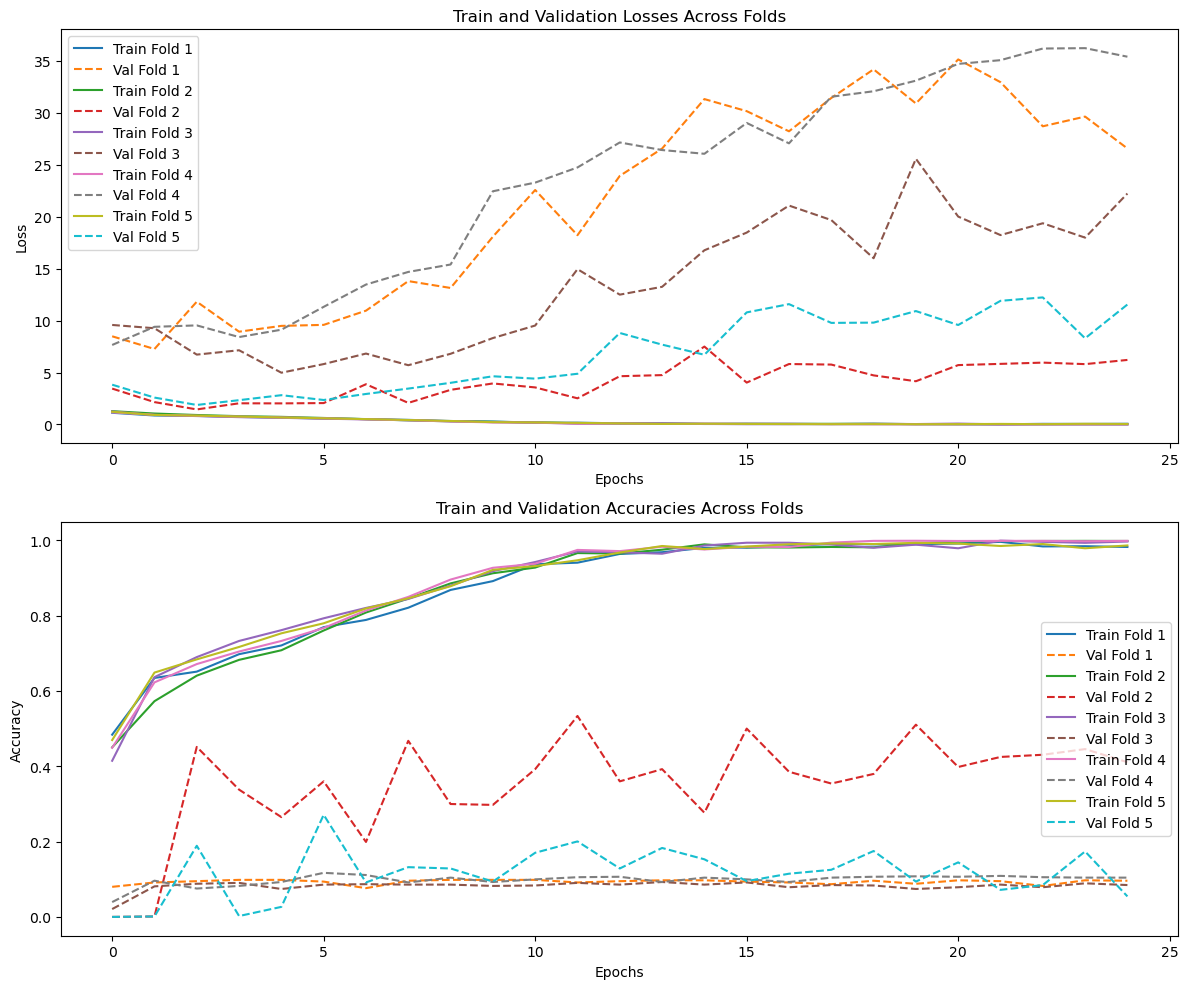

In [16]:
# 各フォールドの結果をまとめてプロット
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
for i in range(len(all_train_losses)):
    plt.plot(all_train_losses[i], label=f'Train Fold {i+1}')
    plt.plot(all_val_losses[i], label=f'Val Fold {i+1}', linestyle='--')
plt.title('Train and Validation Losses Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
for i in range(len(all_train_accuracies)):
    plt.plot(all_train_accuracies[i], label=f'Train Fold {i+1}')
    plt.plot(all_val_accuracies[i], label=f'Val Fold {i+1}', linestyle='--')
plt.title('Train and Validation Accuracies Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
